# 데이터 불러오기

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# data1 = speech_data(['wav_vals'][:30000], ['label_vals'][:30000])
# data2 = speech_data['label_vals'][:30000]


np.array(speech_data)

array(['wav_vals', 'label_vals'], dtype='<U10')

# 데이터셋 확인하기

In [2]:
# 데이터 모양 확인하기
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print(type(speech_data["wav_vals"]))


import IPython.display as ipd
import random

# 데이터 확인
# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"])) # 범위에서 랜덤추출
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
<class 'numpy.ndarray'>
rand num :  42420
Wave data shape :  (8000,)
label :  ['yes']


# 데이터 차원 변환

## Spectogram으로 시각화

## speech_data 자체를 변환하고 split

In [3]:
# 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

## 데이터 변환(wav_vals)

In [4]:
data_list = []
for wav in speech_data['wav_vals']: # 1차원데이터 읽어와서 변환
    x = wav2spec(wav, fft_size=258)
    data_list.append(x)

In [5]:
data_list = np.array(data_list)
print(data_list.shape)

(50620, 130, 126)


# Label data 처리

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()# 딕셔너리여야 가능한 조작
for i, l in enumerate(label_value): # 리스트의 인덱스와 요소에 각각 접근
    new_label_value[l] = i # target_list의 idx와 value를 바꿔서 new_label_value에 저장
label_value = new_label_value

print('Indexed LABEL : ', new_label_value) # value:idx로 변환된 데이터 확인

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [7]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]]) # ?
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

# 학습을 위한 데이터 분리

In [8]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(data_list, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])
del speech_data

In [9]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126)
train labels :  (45558,)
test data :  (5062, 130, 126)
test labels :  (5062,)
✅


In [10]:
#spec = wav2spec(train_wav)
print("Waveform shape : ",train_wav.shape)
print("Spectrogram shape : ",data_list.shape)

Waveform shape :  (45558, 130, 126)
Spectrogram shape :  (50620, 130, 126)


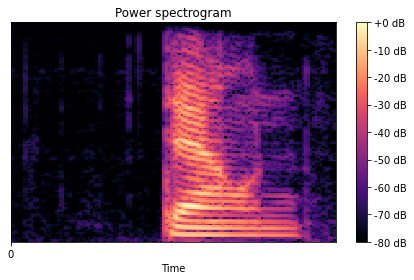

In [11]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(data_list[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()
del data_list

# 하이퍼 파라미터 세팅 및 체크포인트 경로 설정
 * callback함수 사용시 활용

In [12]:
batch_size = 8
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj62/aiffel/speech_recognition/models/wav'

# data setting
 * tf.data.Dataset 사용
 * tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
 * 노드 [E5], [E6]에서 사용

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [14]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label)) # 아래 함수에 인자로 들어감
train_dataset = train_dataset.map(one_hot_label) # 데이터를 불러올 때마다 one-hot encoding(해당값만 1, 나머지는 0으로 인코딩)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


2차원 Spectrogram 데이터를 처리하는 모델 구성
 * 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
 * batchnorm, dropout, dense layer 등을 이용
 * 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
 * 모델 가중치를 저장하는 checkpoint callback 함수 추가
 * 다양한 모델의 실험을 진행해 보시기 바랍니다.

# Wave classification 모델 구현

## 기본모델

In [15]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

# Loss
 * 12개 클래스를 구분하기 위해서 Multi-class Classification이 필요함

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4) # optimizer로는 Adam을, Loss function으로는 Categorical Cross-Entropy loss를 사용
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


# Training
 * model.fit 실행 시, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정 가능
 * 모델을 재사용하기 위해 모델 가중치를 저장하는 callback 함수를 추가

In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [18]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
5687/5694 [============================>.] - ETA: 0s - loss: 1.3474 - accuracy: 0.5443
Epoch 00001: val_loss improved from inf to 0.75223, saving model to /home/aiffel-dj62/aiffel/speech_recognition/models/wav
5694/5694 [==============================] - 26s 5ms/step - loss: 1.3468 - accuracy: 0.5444 - val_loss: 0.7522 - val_accuracy: 0.7441
Epoch 2/10
5683/5694 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.7778
Epoch 00002: val_loss improved from 0.75223 to 0.49151, saving model to /home/aiffel-dj62/aiffel/speech_recognition/models/wav
5694/5694 [==============================] - 26s 5ms/step - loss: 0.6806 - accuracy: 0.7778 - val_loss: 0.4915 - val_accuracy: 0.8402
Epoch 3/10
5687/5694 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8427
Epoch 00003: val_loss improved from 0.49151 to 0.43043, saving model to /home/aiffel-dj62/aiffel/speech_recognition/models/wav
5694/5694 [==============================] - 26s 5ms/step - l

# 학습결과 시각화

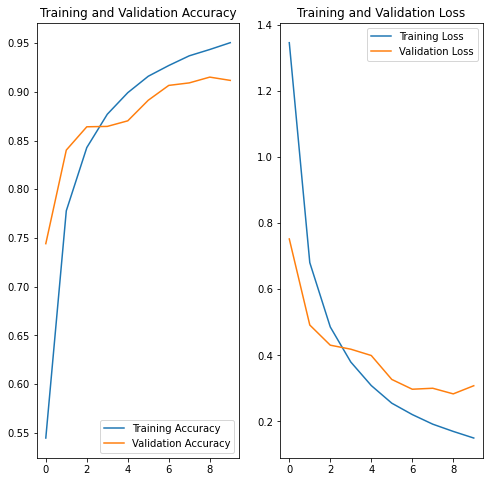

✅


In [19]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

# 성능평가(Evaluation)
 * test_dataset으로 모델의 성능 평가

In [20]:
# checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [21]:
#test_dataset으로 예측값과 실제값의 차이 확인
results = model_wav.evaluate(test_dataset)
print("✅")

633/633 [==============================] - 21s 33ms/step - loss: 0.2826 - accuracy: 0.9153
✅


In [22]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.283
accuracy value: 91.5251%
✅


# 5-5. Skip-Connection model 추가

## Skip-Connection model 구현
 * 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식
 * 구현 방식 - tf.concat([#layer output tensor, layer output tensor#], axis=#)

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 130, 32)      36320       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 130, 32)      9248        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 65, 32)       0           conv1d_1[0][0]                   
______________________________________________________________________________________________

## Loss function 설정

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


## 세이브 포인트

In [18]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## 모델 훈련

In [19]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
5684/5694 [============================>.] - ETA: 0s - loss: 1.4339 - accuracy: 0.5148
Epoch 00001: val_loss improved from inf to 0.81309, saving model to /home/aiffel-dj62/aiffel/speech_recognition/models/wav_skip
5694/5694 [==============================] - 29s 5ms/step - loss: 1.4330 - accuracy: 0.5150 - val_loss: 0.8131 - val_accuracy: 0.7383
Epoch 2/10
5691/5694 [============================>.] - ETA: 0s - loss: 0.7308 - accuracy: 0.7638
Epoch 00002: val_loss improved from 0.81309 to 0.55148, saving model to /home/aiffel-dj62/aiffel/speech_recognition/models/wav_skip
5694/5694 [==============================] - 29s 5ms/step - loss: 0.7307 - accuracy: 0.7638 - val_loss: 0.5515 - val_accuracy: 0.8165
Epoch 3/10
5692/5694 [============================>.] - ETA: 0s - loss: 0.5007 - accuracy: 0.8394
Epoch 00003: val_loss improved from 0.55148 to 0.43660, saving model to /home/aiffel-dj62/aiffel/speech_recognition/models/wav_skip
5694/5694 [==============================] - 2

## 시각화

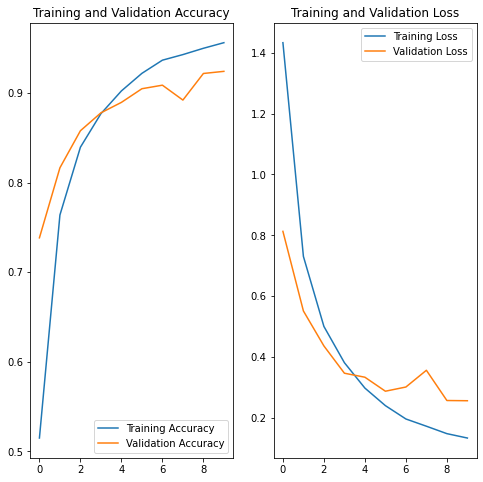

✅


In [20]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 성능평가

In [21]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

633/633 [==============================] - 20s 31ms/step - loss: 0.2562 - accuracy: 0.9241
loss value: 0.256
accuracy value: 92.4141%
✅


### 1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.

 * 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었습니다.

### 2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
 * 스펙트로그램을 입력받은 모델의 loss값과 accuracy 곡선이 정상적으로 수렴하였고, 10회를 진행하는 동안 과적합이 일어나지 않았습니다. 1차원 데이터를 2차원으로 변환하여 이에 따라 evaluation/test 단계를 무리없이 끝냈습니다.

### 3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.

 * evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
   * 두 모델 모두 92% 이상의 정확도를 보였으며, 과적합이 일어나지 않았습니다.
   * batch size를 8로 줄이고 돌렸을 뿐인데 정확도가 높게 나왔습니다. 다른 하이퍼파라미터도 변경해서 실험해보고 싶었지만, 커널이 지속적으로 죽는 현상이 반복되어 실패했습니다.
   * 다만 좋은 아이디어라고 생각했던 skip의 accuracy에 비해 약간 높게 나온것은 의외였습니다. 해당 일반 모델이 데이터에 비해 지나치게 높은 성능을 낸 것인지, 아니면 단순히 skip connection에 맞지 않는 데이터였는지 궁금합니다.

## 회고

1차원 데이터를 2차원으로 바꾸면서 여러 고비가 있었습니다. 어려운 수식이 나와서 부담이 큰 상태에서 노드를 진행하며 커널이 지속적으로 죽어서 하루종일 노드를 끝내지 못했습니다.(심지어 데이터를 지속적으로 지워가면서도 마지막 제출 모델을 일반, skip 2번에 나눠서 돌렸습니다..) 코드를 이해하는데도 엄청나게 많은 시간과 노력을 쏟았지만, 아직 깊이있게 이해하지 못한것이 아쉽습니다. 다른분들에 비해 느리더라도 꾸준히 하기 위해 노력하고 있습니다.

그래도 자연어는 단순히 텍스트데이터만 생각했었는데 음성, 오디오데이터도 접해볼 수 있어서 좋았습니다. 보다 전문적인 지식이 필요하겠지만, 다양하게 활용될 수 있는 분야라는 생각이 들었습니다.